# CS441: Applied ML - HW 4

## Part I: Clustering and Fast Retrieval

Include all the code for Part 1 in this section

In [1]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 0s (988 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd64.

In [10]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

11490434/11490434 [==============================] - 0s 0us/step


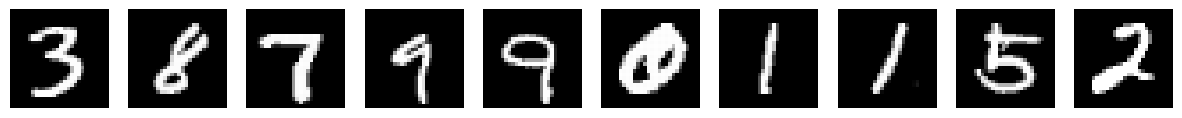

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [11]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

In [4]:
## Helper functions

# Returns the purity of the clustering according to labels, 
# and the label counts of each cluster
def get_purity(labels, cluster_idx):
  nclasses = int(max(labels)+1)
  nidx = int(max(cluster_idx)+1)
  counts = np.zeros((nidx, nclasses), np.int32)
  for i in range(len(labels)):
    c = labels[i]
    idx = cluster_idx[i]
    counts[idx, c]+=1
  purity = np.sum(np.max(counts, axis=1))/len(cluster_idx)
  return purity, counts

# Returns an index list that can be used to re-order the counts according to 
# which label is most common 
def get_cluster_order(counts):
  idx = np.argmax(counts, axis=1)
  idx = np.argsort(idx)
  return idx 

###*Problem* 1.1 Clustering

K=10, Purity=0.591
Cluster Indexes: [0 8 2 4 3 7 6 9 1 5]
Centroids:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Mean Distance=6.163

K=20, Purity=0.706
Cluster Indexes: [16  5  6  7 13 14  4  0 10 15  9 11  8  1 12 17  3 19  2 18]
Centroids:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Mean Distance=5.826

K=30, Purity=0.765
Cluster Indexes: [ 2 20  7 15 29  1  4 17  9 13 27 12  0  6 19 11 26 18 25 10  3  8 24 21
 23 28 14 22  5 16]
Centroids:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Mean Distance=5.637

K=40, Purity=0.787
Cluster Indexes: [ 0 36 13 12 33 38 31  8 18 32  4 35 20 16  6 29  1  7 39 15  9 22 28 27
 37 34 11 14 19 23 21  3  2 26 24 30  5 25

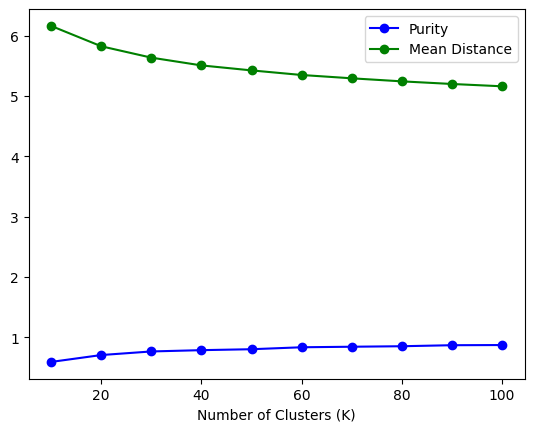

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# set dimensions
dim = x_train.shape[1]

# Set the number of clusters
clusters =  [10, 20, 30,40,50,60,70,80,90, 100]

purity_k = []
mean_k = []

for K in clusters:
  # Initialize the k-means clustering object
  kmeans = KMeans(n_clusters=K, n_init=10, max_iter=300)

  # Train the k-means model
  kmeans.fit(x_train)

  # Assign each data point to a cluster
  cluster_idx = kmeans.predict(x_train)

  # Record and print Purity
  purity, counts = get_purity(y_train, cluster_idx)
  purity_k.append(purity)
  print(f'K={K}, Purity={purity:.3f}')

  #Get Cluster indexes & Display the centroids
  order = get_cluster_order(counts)
  print(f'Cluster Indexes: {order}')
  centroids = kmeans.cluster_centers_[order]
  print(f'Centroids:\n{centroids}')

  # Record and print Average Distance
  dists = kmeans.transform(x_train)
  mean_dist = np.mean(np.min(dists, axis=1))
  mean_k.append(mean_dist)
  print(f'Mean Distance={mean_dist:.3f}\n')

#Plot K vs Purity and K vs Mean_Distances
plt.plot(clusters, purity_k, 'bo-', label='Purity')
plt.plot(clusters, mean_k, 'go-', label='Mean Distance')
plt.xlabel('Number of Clusters (K)')
plt.legend()
plt.show()

### Problem 1.2 Fast Retrieval

In [6]:
# set dimensions
dim = x_train.shape[1]

# Initialize the index for Brute Force
index_flatl2 = faiss.IndexFlatL2(dim)

# Add data
index_flatl2.add(x_train)

# Perform search
distances, indices = index_flatl2.search(x_test, 1)

# Compute test error
test_error = 1 - np.mean(y_train[indices[:, 0]] == y_test)

# Initialize the index for LSH
nbits = dim // 2
index_lsh = faiss.IndexLSH(dim, nbits)

# Add data
index_lsh.add(x_train)

# Perform search
distances, indices = index_lsh.search(x_test, 1)

# Compute test error
test_error = 1 - np.mean(y_train[indices[:, 0]] == y_test)

# Time to add data
start_time_add = time.time()
index_flatl2.add(x_train)
time_add = time.time() - start_time_add

# Time to search
start_time_search = time.time()
distances, indices = index_flatl2.search(x_test, 1)
time_search = time.time() - start_time_search

# Compute test error
test_error = 1 - np.mean(y_train[indices[:, 0]] == y_test)

print("Test error:", test_error)
print("Time to add data:", time_add)
print("Time to search:", time_search)



Test error: 0.03310000000000002
Time to add data: 0.34406065940856934
Time to search: 26.815205812454224


In [8]:
# set dimensions
dim = x_train.shape[1]

start_time = time.time()

# Initialize the index for LSH
nbits = int(dim/2)
index_lsh = faiss.IndexLSH(dim, nbits)

# Add Data & Print time to add
index_lsh.add(x_train)
print("Time to add: {:.5f} s".format(time.time()-start_time))

# Perform Search and Compute Time required
start_time = time.time()
D, I = index_lsh.search(x_test, 1)
print("Time to search: {:.5f} s".format(time.time()-start_time))

# Compute Test Error
test_error = 1 - np.mean(y_test == y_train[I[:, 0]])
print("Test error: {:.4f}".format(test_error))
print(nbits)

Time to add: 1.72782 s
Time to search: 5.53997 s
Test error: 0.0425
392


## Part 2: Estimating PDFs

In [2]:
!apt install libomp-dev
!pip install faiss-cpu
!pip install cv2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 0s (1,522 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 122352 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd6

In [3]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

Mounted at /content/drive


In [4]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

#### Method 1 (Per-dimension discrete pdf)

In [19]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  for i in range(len(x)):
    p[x[i]] += 1
  p /= np.sum(p)
  return p


In [20]:
# set number of bins K
K = 50

# reshape pixels to (h*w, 3)
im_pixels = np.reshape(im, (-1, 3))

# convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
im_pixels = np.minimum((im_pixels*K).astype(int), K-1)

# get pdf for each dimension using estimate_discrete_pdf
pdfs = []
for i in range(3):
    pdf = estimate_discrete_pdf(im_pixels[:,i], K)
    pdfs.append(pdf)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0]*im.shape[1],))
for i in range(3):
    score_map += np.log(pdfs[i][im_pixels[:,i]])

# display
display_score_maps(im, score_map, -2)
display_score_maps(im, score_map, -1)
display_score_maps(im, score_map, 0)
display_score_maps(im, score_map, 1)
display_score_maps(im, score_map, 2)


Output hidden; open in https://colab.research.google.com to view.

#### Method 2 (K-means)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


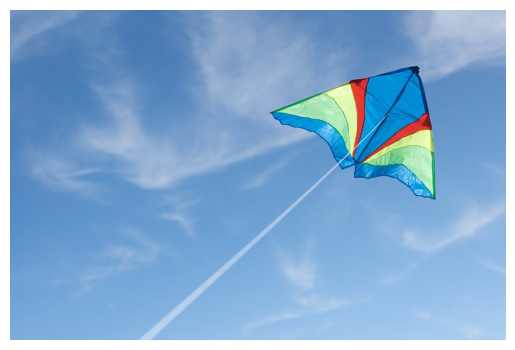

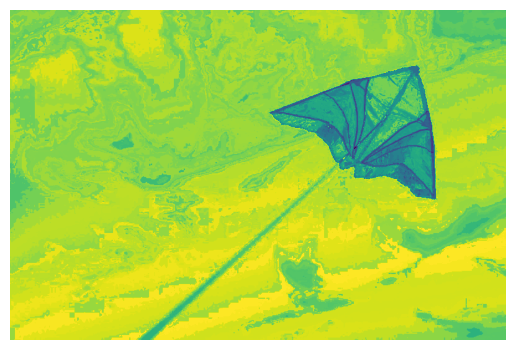

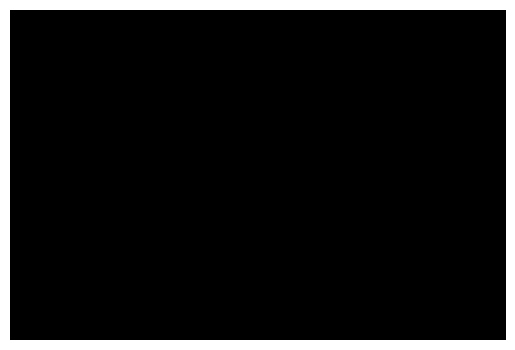

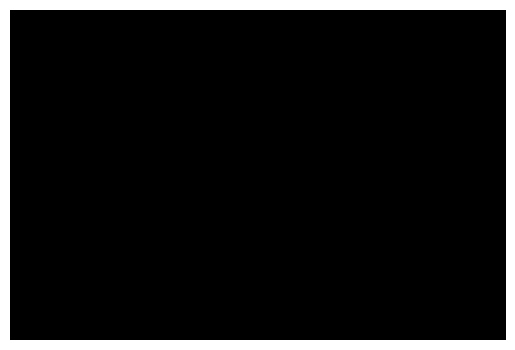

In [17]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
from sklearn.cluster import KMeans

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

# set K
K = 256

# reshape pixels to (h*w, 3)
pixels = im.reshape(-1, 3)

# discretize all three color channels together using KMeans
kmeans = KMeans(n_clusters=K, random_state=0).fit(pixels)
discrete_values = kmeans.predict(pixels)

# get pdf over discrete values
counts = np.bincount(discrete_values, minlength=K)
pdf = counts / np.sum(counts)

# estimate score for each pixel in full image according to log pdfs
scores = np.zeros_like(discrete_values, dtype=np.float32)
for i in range(K):
    scores[discrete_values == i] = np.log(pdf[i])

# display
display_score_maps(im, scores.reshape(im.shape[:2]), -1.5)
display_score_maps(im, scores.reshape(im.shape[:2]), -2.0)
display_score_maps(im, scores.reshape(im.shape[:2]), -1.0)
display_score_maps(im, scores.reshape(im.shape[:2]), 0.0)
display_score_maps(im, scores.reshape(im.shape[:2]), 1.0)
display_score_maps(im, scores.reshape(im.shape[:2]), 2.0)

#### Method 3 (GMM)

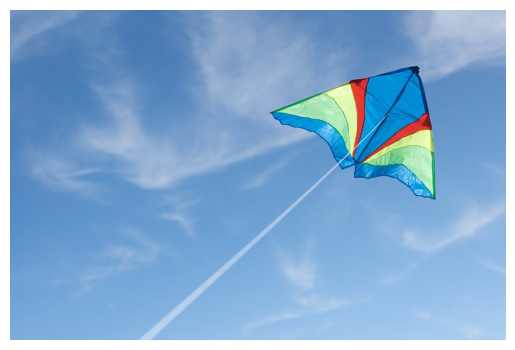

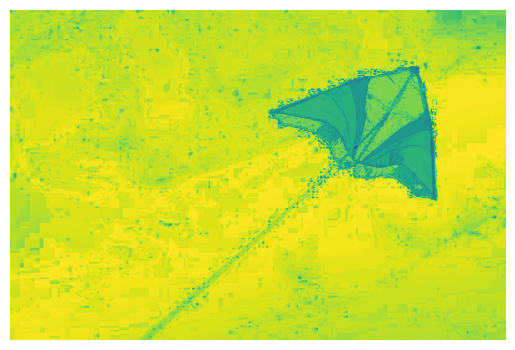

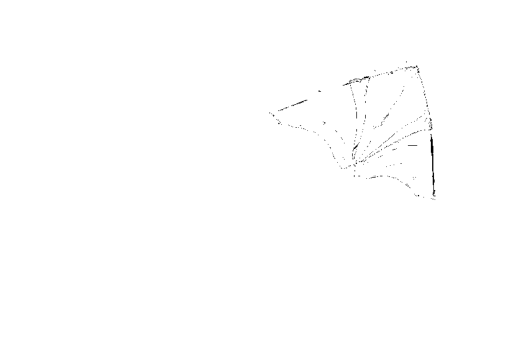

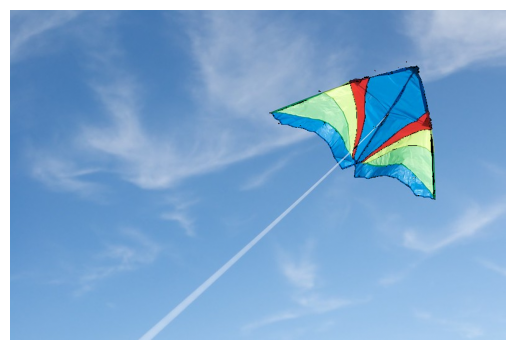

In [19]:
from sklearn.mixture import GaussianMixture

# reshape pixels to (h*w, 3)
pixels = im.reshape((-1, 3))

# get joint pdf using GMMs (choose number of components and other parameters)
n_components = 5
cov_type = 'full' # 'full' or 'diag'
gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type)
gmm.fit(pixels)
log_prob = gmm.score_samples(pixels)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0]*im.shape[1], 1))
score_map[:,0] = log_prob

# display
thresh = -4.5
display_score_maps(im, score_map, thresh)


## Part 3: PCA and Data Compression

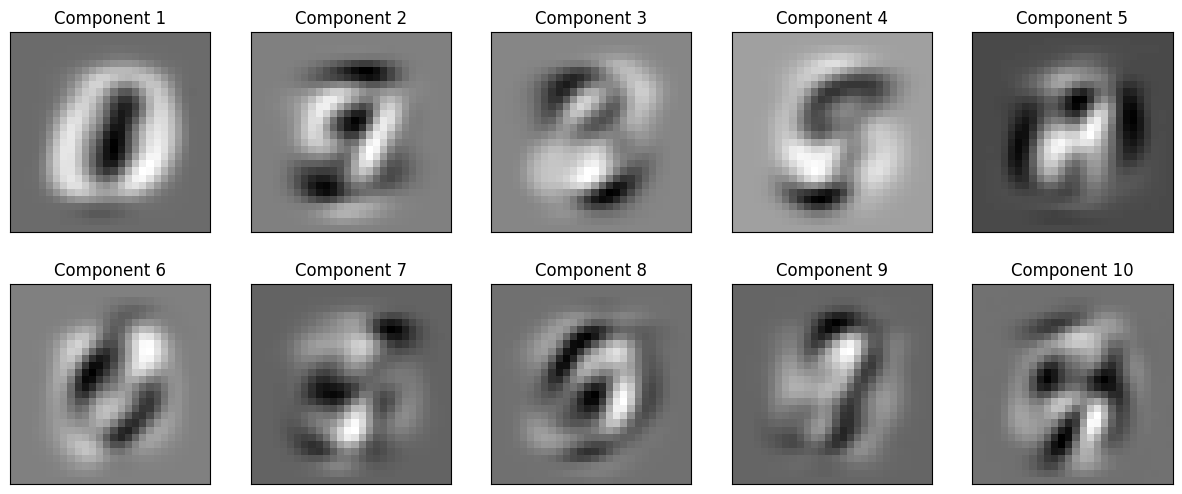

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import faiss

(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Compute the first 10 principal components using x_train
pca = PCA(n_components=10)
pca.fit(x_train)
components = pca.components_

# Display First 10 Components
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(components[i].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Component {i+1}")
plt.show()


<Axes: >

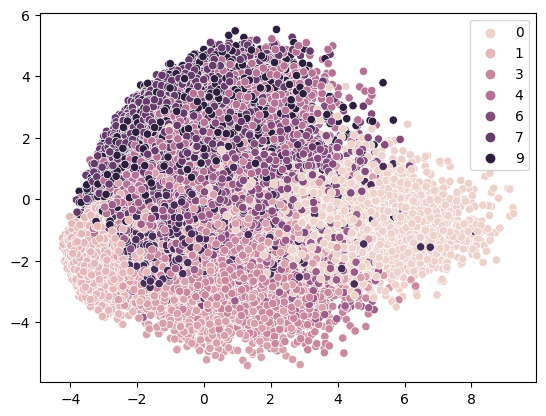

In [8]:
# Scatter plot of first two PCA dimensions
import seaborn as sns  #sns.scatterplot(x, y, hue=labels)
pca = PCA(n_components=2)
pca.fit(x_train)
components = pca.transform(x_train)

sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=y_train)


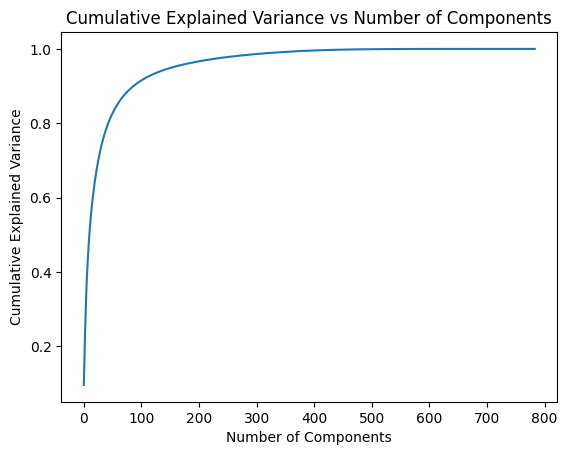

In [9]:
# Plot cumulative explained variance
pca = PCA()
pca.fit(x_train)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.show()




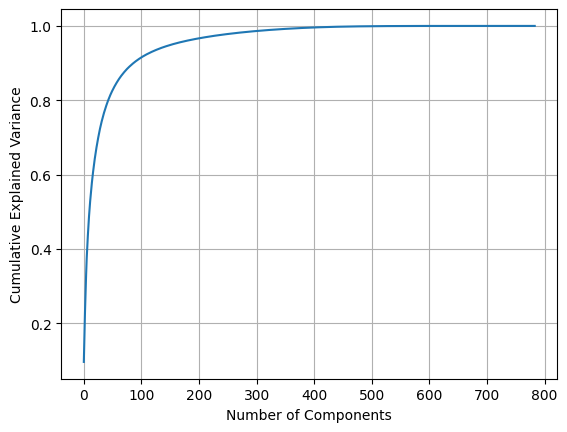

Selected 88 components to explain 90% of variance.


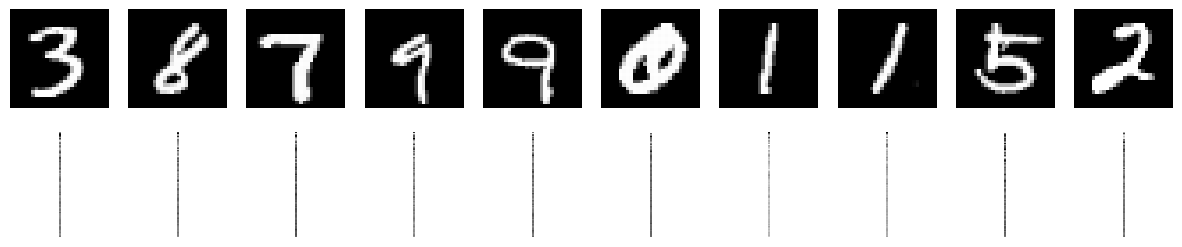

Time to add 50000 vectors: 0.028 seconds
Time to perform 10000 queries: 2.168 seconds
Test error: 0.0289


In [16]:
import time
import numpy as np
import faiss

# Load MNIST data
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Compute the principal components using x_train
pca = PCA()
pca.fit(x_train)

# Plot variance explained by each principal component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Select number of dimensions that explains 90% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Selected {n_components} components to explain 90% of variance.")

# Compress data using the first n_components principal components
x_train_compressed = pca.transform(x_train)[:, :n_components]
x_test_compressed = pca.transform(x_test)[:, :n_components]

# Display the first 10 samples before and after PCA compression
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0, i].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(x_train_compressed[i].reshape(-1, 1), cmap='gray')
    axs[1, i].axis('off')
plt.show()

# Initialize the index for Brute Force
#d = n_components
index = faiss.IndexFlatL2(88)

# Add Data & Print time to add
t0 = time.time()
index.add(x_train_compressed.astype('float32'))
print(f"Time to add {x_train_compressed.shape[0]} vectors: {time.time()-t0:.3f} seconds")

# Perform Search and Compute Time required
k = 1  # Number of nearest neighbors to search for
n_queries = x_test_compressed.shape[0]
t0 = time.time()
D, I = index.search(x_test_compressed.astype('float32'), k)
search_time = time.time()-t0
print(f"Time to perform {n_queries} queries: {search_time:.3f} seconds")

# Compute Test Error
y_pred = y_train[I[:, 0]]
test_error = 1 - np.mean(y_pred == y_test)
print(f"Test error: {test_error:.4f}")


In [15]:
d

88

## Part 4: Stretch Goals
Include all your code used for part 4 in this section. You can copy-paste code from parts 1, 2 or 3 if it is re-usable.

In [14]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#stretch goal #1
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Load CIFAR-10 data and preprocess
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_test = x_test.astype('float32') / 255.0

model_path = 'cifar10_model.h5'
if not os.path.isfile(model_path):
    raise OSError(f"No file found at {model_path}")

# Load the model
model = load_model(model_path)


# Select sample image from test set
image_index = 0
sample_image = x_test[image_index]
sample_label = y_test[image_index]

# Generate score map and segmentation using original approach
probs = model.predict(np.expand_dims(sample_image, axis=0))[0]
score_map = np.max(probs, axis=-1)
segmentation = np.argmax(probs, axis=-1)

# Use PCA to rotate per-channel probability estimates
pca = PCA(n_components=3)
pca.fit(probs)
rotated_probs = pca.transform(probs)

# Generate score map and segmentation using rotated probabilities
rotated_score_map = np.max(rotated_probs, axis=-1)
rotated_segmentation = np.argmax(rotated_probs, axis=-1)

# Plot original and rotated score maps and segmentations side by side
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(sample_image)
axs[0, 0].set_title(f"True Label: {sample_label}")
axs[0, 1].imshow(score_map, cmap='jet')
axs[0, 1].set_title("Original Score Map")
axs[1, 0].imshow(segmentation)
axs[1, 0].set_title("Original Segmentation")
axs[1, 1].imshow(rotated_score_map, cmap='jet')
axs[1, 1].set_title("Rotated Score Map")
plt.show()

# Compute IoU and MAE between original and rotated segmentations
iou = np.sum(segmentation == rotated_segmentation) / np.prod(segmentation.shape)
mae = np.mean(np.abs(segmentation - rotated_segmentation))
print(f"IoU: {iou:.4f}")
print(f"MAE: {mae:.4f}")


170498071/170498071 [==============================] - 7s 0us/step


OSError: ignored

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


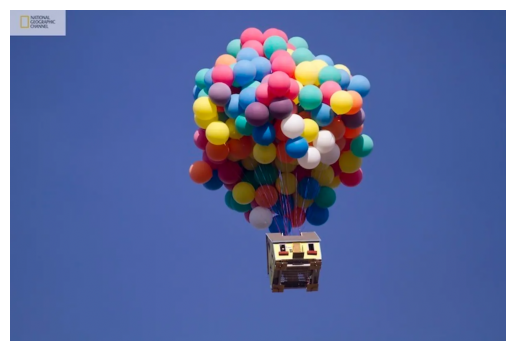

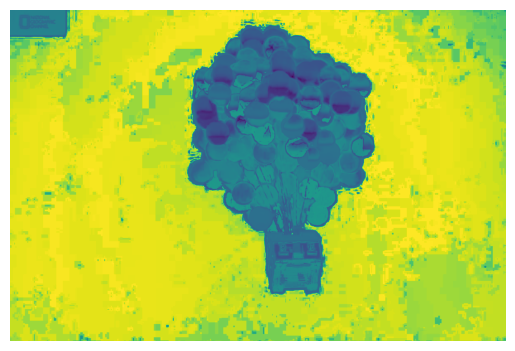

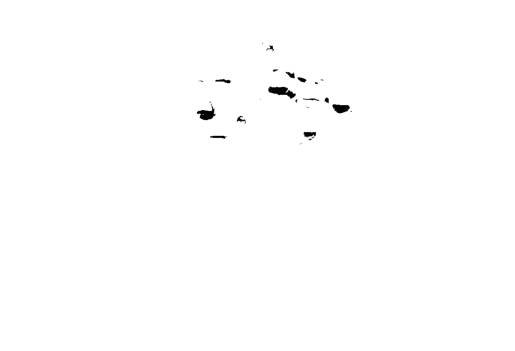

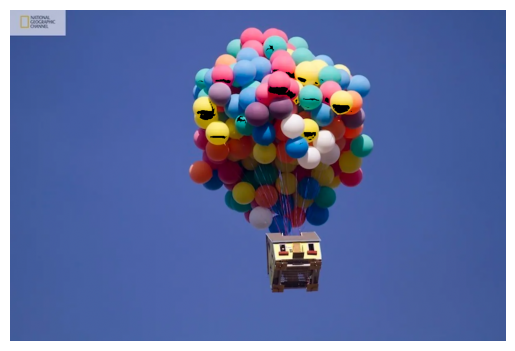

In [5]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + 'NationalGeographicChannel9.webp')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1


from sklearn.mixture import GaussianMixture

# reshape pixels to (h*w, 3)
pixels = im.reshape((-1, 3))

# get joint pdf using GMMs (choose number of components and other parameters)
n_components = 5
cov_type = 'full' # 'full' or 'diag'
gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type)
gmm.fit(pixels)
log_prob = gmm.score_samples(pixels)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0]*im.shape[1], 1))
score_map[:,0] = log_prob

# display
thresh = -4.5
display_score_maps(im, score_map, thresh)


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


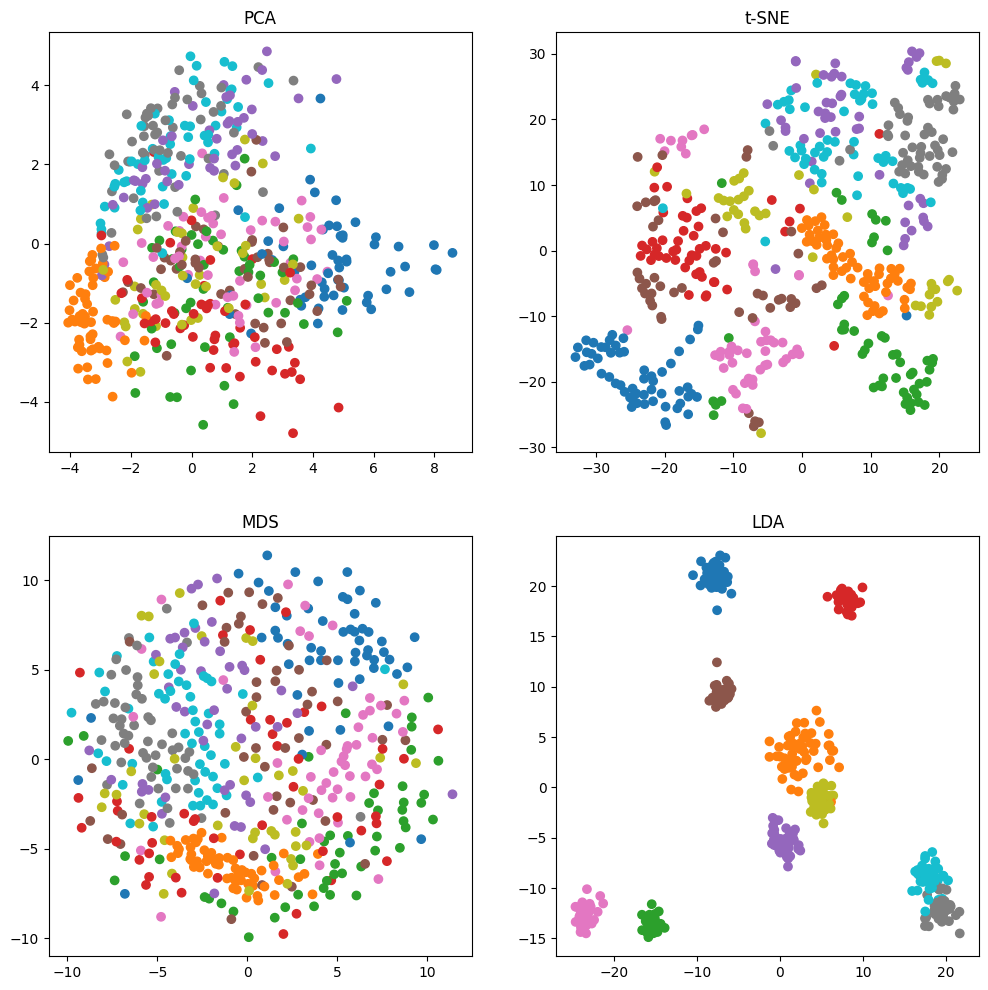

In [14]:
#stretch goal #3
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Compute PCA on the training data
pca = PCA(n_components=2)
pca.fit(x_train)
pca_transformed = pca.transform(x_train[train_indices['s']])

# Compute t-SNE on the training data
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(x_train[train_indices['s']])

# Compute MDS on the training data
mds = MDS(n_components=2, random_state=42)
mds_transformed = mds.fit_transform(x_train[train_indices['s']])

# Compute LDA on the training data
lda = LDA(n_components=2)
lda_transformed = lda.fit_transform(x_train[train_indices['s']], y_train[train_indices['s']])

# Plot the scatterplots side by side
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=y_train[train_indices['s']], cmap='tab10')
axs[0, 0].set_title('PCA')

axs[0, 1].scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=y_train[train_indices['s']], cmap='tab10')
axs[0, 1].set_title('t-SNE')

axs[1, 0].scatter(mds_transformed[:, 0], mds_transformed[:, 1], c=y_train[train_indices['s']], cmap='tab10')
axs[1, 0].set_title('MDS')

axs[1, 1].scatter(lda_transformed[:, 0], lda_transformed[:, 1], c=y_train[train_indices['s']], cmap='tab10')
axs[1, 1].set_title('LDA')

plt.show()
